# W266 Final Project

### Classifying the Political Ideology of News Articles

#### Matt Accociamessa and Megan Pera

In [1]:
%matplotlib inline

# Import genderal libraries
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
import scipy as sp
import collections
import matplotlib.pyplot as plt
import itertools
import re
import os
import time
import datetime
from tensorflow.contrib import learn
import csv
from collections import defaultdict

# Libraries for Baseline MNB
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import metrics


# Libraries for CLIP model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Libraries for LSTM/CNN
from shared_lib import vocabulary, utils, utils_ideo
import rnnlm
import tensorflow as tf
from gensim.models import word2vec
import json, shutil, sys
import nltk


# Libraries for article scraping
import string
import urllib.request
import httplib2
import requests
from requests.exceptions import ConnectionError, RequestException
from bs4 import BeautifulSoup, SoupStrainer



/Users/megan/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/megan/anaconda/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading, Cleaning and Exploring Data

In [2]:
# Load and save data into liberal, conservative and neutral objects
[lib, con, neutral] = pickle.load(open('ibcData.pkl', 'rb'))

In [3]:
# Data samples, by classification
print ('Liberal examples (out of ', len(lib), ' sentences): ')
for tree in lib[0:5]:
    print(tree.get_words())
    
print ('\nConservative examples (out of ', len(con), ' sentences): ')
for tree in con[0:5]:
    print (tree.get_words())
    
print ('\nNeutral examples (out of ', len(neutral), ' sentences): ')
for tree in neutral[0:5]:
    print (tree.get_words())

Liberal examples (out of  2025  sentences): 
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most .
Because it would not be worthwhile to bring a case for $ 30.22 , the arbitration clause would , as a practical matter , deny the Concepcions any relief and , more important , eliminate a class action that might punish AT&T for its pattern of fraudulent behavior .
Indeed , Lind argues that high profits and high wages reinforce each other because workers then have the wherewithal to buy the products they are making .
In fairness , it should be noted that he devotes an entire chapter to New York Times political columnist Maureen Dowd , a liberal who makes much of the outsized rivalries , jealousies , and personalities that dominate American politics .
Psychological tactics are social control techniques that operate at the level of the mind , with th

In [4]:
# Formatting data into workable arrays
liberal = np.array(lib)
conserv = np.array(con)
neut = np.array(neutral)

# Seprating data and labels
def separate_data_and_labels(label_class):
    labels = []
    data = []
    for i in range(len(label_class)):
        for node in label_class[i]:
            if hasattr(node, 'label'):
                data.append(node.get_words())
                labels.append(node.label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

lib_data, lib_labs = separate_data_and_labels(liberal)
con_data, con_labs = separate_data_and_labels(conserv)
neut_data, neut_labs = separate_data_and_labels(neut)
conmult = (len(lib_data))/(len(con_data))
neutmult = (len(lib_data))/(len(neut_data))

In [5]:
print('Examples:')
print ('\n Liberal')
print(lib_data[0],'\n',lib_labs[0:10])
print ('\n Conservative')
print(con_data[0],'\n',con_labs[0:10])
print ('\n Neutral')
print(neut_data[0],'\n',neut_labs[0:10])

Examples:

 Liberal
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most . 
 ['Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal'
 'Liberal' 'Liberal' 'Liberal']

 Conservative
Gore is getting rich from environmentalism , not just by being paid a whopping $ 175,000 per speech but by using political pressure to force government policy in a direction that benefits his business interests . 
 ['Conservative' 'Conservative' 'Conservative' 'Conservative' 'Neutral'
 'Neutral' 'Neutral' 'Conservative' 'Liberal' 'Liberal']

 Neutral
In this country , the beneficiaries of Apple 's success are , first , the designers , who have done wonders working with Steve Jobs to produce products that are beautiful and effective . 
 ['Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral'
 'Neutral' 'Neutral' 'Neutral']


In [6]:
# Combining into one dataset
data_all = np.concatenate((neut_data, lib_data, con_data), axis=0)
labs_all = np.concatenate((neut_labs, lib_labs, con_labs), axis=0)

print (data_all.shape)
print (labs_all.shape)

(22621,)
(22621,)


In [7]:
# Randomly mixing data&labels so that they can be split into test and train
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

data_all, labs_all = shuffle_in_unison(data_all, labs_all)

In [8]:
# Split data into test (20%) and train (80%)
slice = int(.8*labs_all.shape[0])
data_train = data_all[:slice]
labs_train = labs_all[:slice]
data_test = data_all[slice:]
labs_test = labs_all[slice:]
print(labs_all.shape)
print(labs_test.shape)
print(labs_train.shape)

(22621,)
(4525,)
(18096,)


In [9]:
# Turning dataset into word tokens
count_vect = CountVectorizer()
data = count_vect.fit_transform(data_train).toarray()
vocab = count_vect.get_feature_names()

# Counting the number of times each word appears
np.clip(data,0,1, out = data) #make sure each word only appears once in the array
dist = np.sum(data, axis = 0) #sum the columns
counts = list(zip(vocab,dist)) #zip counts and words together

# Total vocab size and word count
print("Total word count:",np.sum(dist))
print("Vocabulary size:",len(vocab))

Total word count: 309335
Vocabulary size: 14127


In [12]:
# Printing out the 10 most popular words
counts = sorted(counts, key=lambda x: x[1], reverse=True) 
counts[0:10]

[('the', 10985),
 ('and', 7948),
 ('of', 7903),
 ('to', 7616),
 ('that', 4746),
 ('in', 4545),
 ('for', 3462),
 ('by', 2287),
 ('is', 2207),
 ('on', 2043)]

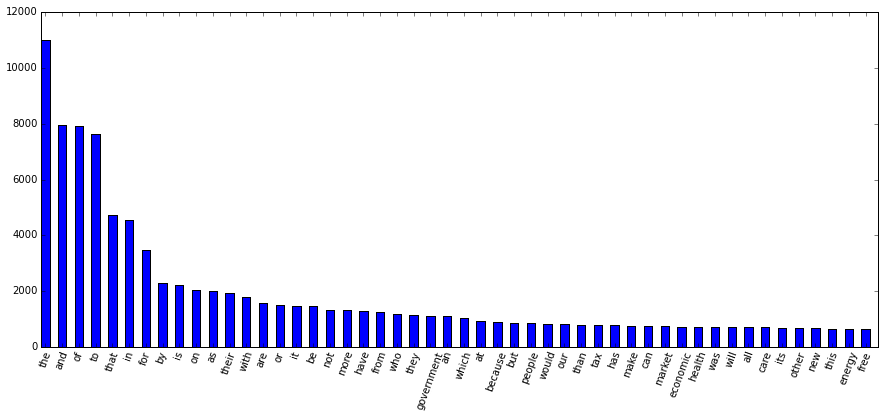

In [13]:
# Plotting top 50 results
ordered = list(zip(*counts))
x = ordered[0][:50] #counts
y = ordered[1][:50] #words

# Plotting figure
fig = plt.figure(figsize=(15.0,6.0))
indexes = np.arange(50)
width = .5
plt.bar(indexes, y, width)
plt.xticks(indexes + width * 0.5, x,rotation=70)
plt.show()

## Baseline Model: Multinomial Naive Bayes


In [14]:
# This model predicts the political leanings of sentences and sub-sentences

# Training the model
vect = CountVectorizer()
train_vocab = vect.fit_transform(data_train)
test_vocab = vect.transform(data_test)

# Scoring the model
print("")
print("Multinomial Naive Bayes:")
for a in [0.0001, 0.01, .05, 0.1, 0.2, 1.0]:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(train_vocab, labs_train)
    mnbpreds = mnb.predict(test_vocab)
    print("alpha:", a, "F1:", mnb.score(test_vocab, labs_test))


Multinomial Naive Bayes:
alpha: 0.0001 F1: 0.73546961326
alpha: 0.01 F1: 0.731933701657
alpha: 0.05 F1: 0.730828729282
alpha: 0.1 F1: 0.725524861878
alpha: 0.2 F1: 0.72044198895
alpha: 1.0 F1: 0.702541436464


In [15]:
# Showing examples for alpha = 0.001
mnb = MultinomialNB(alpha=0.001)
mnb.fit(train_vocab, labs_train)
mnbpreds = mnb.predict(test_vocab)
mnbpred_prob = mnb.predict_proba(test_vocab)
probs = list(zip(data_test.tolist(),mnbpreds.tolist(),mnbpred_prob.tolist()))

for i in range(0,5):
    print('Sentence:',probs[i][0])
    print('Actual Label:',labs_test[i])
    print('Predicted Label:',probs[i][1])
    print('Predicted Label Probability:', max(probs[i][2]),'\n')

Sentence: an alliance between the public groups that define the need for regulation and those parts of business that make it a success
Actual Label: Liberal
Predicted Label: Liberal
Predicted Label Probability: 0.9907203988545072 

Sentence: the economy as a whole
Actual Label: Neutral
Predicted Label: Neutral
Predicted Label Probability: 0.6058666778884277 

Sentence: spent on the program as spending rages out of control
Actual Label: Conservative
Predicted Label: Conservative
Predicted Label Probability: 0.9999416910055227 

Sentence: easy access to our country
Actual Label: Neutral
Predicted Label: Liberal
Predicted Label Probability: 0.4811325108987772 

Sentence: been designated high-risk targets for terrorism , because that means more dollars , more jobs , more shiny riot gear ...
Actual Label: Conservative
Predicted Label: Conservative
Predicted Label Probability: 0.999999999980588 



In [16]:
# Probability error analysis
errors = []
correct_probs = []
incorrect_probs = []
for i in range(0,len(probs)):
    if labs_test[i] == probs[i][1]:
        correct_probs.append(max(probs[i][2]))
    else:
        errors.append(i)
        incorrect_probs.append(max(probs[i][2]))

# Mislabels error analysis
correct_labels = defaultdict(int)
con_as_neut = 0
con_as_lib = 0
lib_as_neut = 0
lib_as_con = 0
neut_as_con = 0
neut_as_lib = 0

for i in range(0,len(probs)):
    if labs_test[i] == probs[i][1]:
        correct_labels[labs_test[i]] += 1
    else:
        if labs_test[i] == 'Conservative' and probs[i][1] == 'Neutral':
            con_as_neut += 1
        elif labs_test[i] == 'Conservative' and probs[i][1] == 'Liberal':
            con_as_lib += 1
        elif labs_test[i] == 'Neutral' and probs[i][1] == 'Liberal':
            neut_as_lib += 1
        elif labs_test[i] == 'Neutral' and probs[i][1] == 'Conservative':
            neut_as_con += 1
        elif labs_test[i] == 'Liberal' and probs[i][1] == 'Neutral':
            lib_as_neut += 1
        elif labs_test[i] == 'Liberal' and probs[i][1] == 'Conservative':
            lib_as_con += 1
        
# Getting overall phrase label distribution
labels = defaultdict(int)
for i in range(labs_test.shape[0]):
    labels[labs_test[i]] += 1

In [17]:
# Comparing overall distribution of sentences to correctly labeled sentences
for key in labels:
    print('Number of incorrectly labeled', key, 'labels:',labels[key] - correct_labels[key])

Number of incorrectly labeled Liberal labels: 292
Number of incorrectly labeled Neutral labels: 623
Number of incorrectly labeled Conservative labels: 290


In [18]:
print('Number of conservative phrases labeled as neutral:',con_as_neut)
print('Number of conservative phrases labeled as liberal:',con_as_lib)
print('Number of liberal phrases labeled as neutral:',lib_as_neut)
print('Number of liberal phrases labeled as conservative:',lib_as_con)
print('Number of neutral phrases labeled as conservative:',neut_as_con)
print('Number of neutral phrases labeled as liberal:',neut_as_lib)

Number of conservative phrases labeled as neutral: 75
Number of conservative phrases labeled as liberal: 215
Number of liberal phrases labeled as neutral: 107
Number of liberal phrases labeled as conservative: 185
Number of neutral phrases labeled as conservative: 260
Number of neutral phrases labeled as liberal: 363


In [21]:
# Printing out examples of mistakes
print('MNB missclassified',len(errors),'phrases','\n')

for i in errors[0:5]:
    print('Sentence:',probs[i][0])
    print('Actual Label:',labs_test[i])
    print('Predicted Label:',probs[i][1])
    print('Predicted Label Probability:', max(probs[i][2]),'\n')

MNB missclassified 1205 phrases 

Sentence: easy access to our country
Actual Label: Neutral
Predicted Label: Liberal
Predicted Label Probability: 0.4811325108987772 

Sentence: Criminalizing abortion would not , for instance , address the needs of women who seek an abortion because they lacked contraception or were raped or are living in abusive relationship , or will have to drop out of work or school to raise a child alone , or are stretched so thin that they can not emotionally or financially provide for their other children .
Actual Label: Liberal
Predicted Label: Conservative
Predicted Label Probability: 0.5638281155536243 

Sentence: been the preferred solution of the right , which has argued for a move toward high-deductible care , in which individuals bear more financial risk and vulnerability
Actual Label: Liberal
Predicted Label: Conservative
Predicted Label Probability: 0.8534489604720796 

Sentence: have been made in the system of subsidies for agrofuels
Actual Label: Neut

## CLIP Model

In [41]:
# Turning dataset into word tokens for split sets

# Lib data
count_vect = CountVectorizer()
data = count_vect.fit_transform(lib_data).toarray()
vocab = count_vect.get_feature_names()

# Counting the number of times each word appears
np.clip(data,0,1, out = data) #make sure each word only appears once in the array
dist = np.sum(data, axis = 0) #sum the columns
counts = list(zip(vocab,dist)) #zip counts and words together
counts = sorted(counts, key=lambda x: x[1], reverse=True)
ordereda = list(zip(*counts))
xxa = ordereda[0] #words
yya = ordereda[1] #counts
libdict = dict()
for i in range(len(xxa)):
    libdict.update({xxa[i]: yya[i]})

# Con data
count_vect = CountVectorizer()
data = count_vect.fit_transform(con_data).toarray()
vocab = count_vect.get_feature_names()

# Counting the number of times each word appears
np.clip(data,0,1, out = data) #make sure each word only appears once in the array
dist = np.sum(data, axis = 0) #sum the columns
counts = list(zip(vocab,dist)) #zip counts and words together
counts = sorted(counts, key=lambda x: x[1], reverse=True)
orderedb = list(zip(*counts))
xxb = orderedb[0] #words
yyb = orderedb[1] #counts
condict = dict()
for i in range(len(xxb)):
    condict.update({xxb[i]: yyb[i]})

# Neut data
count_vect = CountVectorizer()
data = count_vect.fit_transform(neut_data).toarray()
vocab = count_vect.get_feature_names()

# Counting the number of times each word appears
np.clip(data,0,1, out = data) #make sure each word only appears once in the array
dist = np.sum(data, axis = 0) #sum the columns
counts = list(zip(vocab,dist)) #zip counts and words together
counts = sorted(counts, key=lambda x: x[1], reverse=True)
orderedc = list(zip(*counts))
xxc = orderedc[0] #words
yyc = orderedc[1] #counts
neutdict = dict()
for i in range(len(xxc)):
    neutdict.update({xxc[i]: yyc[i]})

In [42]:
l = pd.DataFrame.from_dict(libdict, orient='index')
c = pd.DataFrame.from_dict(condict, orient='index')
n = pd.DataFrame.from_dict(neutdict, orient='index')

comps = pd.concat([l, c, n], axis=1)
comps2 = comps.fillna(0)
comps2.columns= (['lib','con','neut'])

comps2.loc[:,'con'] *= conmult
comps2.loc[:,'neut'] *= neutmult

word = []
diff = []
most = []

for i in range(len(comps)):
    word.append(comps2.index[i])
    rowvals = []
    for j in range(len(comps2.columns)):
        rowvals.append(comps2.iloc[i,j])
    if max(rowvals) == rowvals[0]:
        most.append('lib')
    elif max(rowvals) == rowvals[1]:
        most.append('con')
    else:
        most.append('neut')
    rowvals.sort()
    diff.append((rowvals[-1]-rowvals[-2])*((rowvals[-1]-rowvals[-2])/rowvals[-1]))

comps2

,lib,con,neut
000,64,31.992188,62.239954
01,1,0.000000,0.000000
03,2,0.000000,0.000000
06,4,0.000000,0.000000
08,5,0.000000,0.000000
09,6,0.000000,0.000000
093,0,0.000000,3.111998
10,25,26.660156,28.007979
100,23,13.330078,43.567968
1000,3,0.000000,0.000000


In [43]:
liblist = []
liblistb = []
conlist = []
conlistb = []
neutlist = []
neutlistb = []

for i in range(len(word)):
    if most[i] == 'lib':
        liblist.append(word[i])
        liblistb.append(diff[i])
    elif most[i] == 'con':
        conlist.append(word[i])
        conlistb.append(diff[i])
    else:
        neutlist.append(word[i])
        neutlistb.append(diff[i])

libs = np.column_stack((liblist, liblistb))
cons = np.column_stack((conlist, conlistb))
neuts = np.column_stack((neutlist, neutlistb))

dictsize = 3000

libcues = []
libs2 = libs[libs[:,1].argsort()[::-1]]
# print("")
# print("Liberal:")
for i in range(dictsize):
#     print(libs2[i][0])
    libcues.append(libs2[i][0])

concues = []
cons2 = cons[cons[:,1].argsort()[::-1]]
# print("")
# print("Conservative:")
for i in range(dictsize):
#     print(cons2[i][0])
    concues.append(cons2[i][0])

neutcues = []
neuts2 = neuts[neuts[:,1].argsort()[::-1]]
# print("")
# print("Neutral:")
for i in range(dictsize):
#     print(neuts2[i][0])
    neutcues.append(neuts2[i][0])

In [44]:
length = len(data_all)
clip = np.zeros((length, 90))

for i in range(length):
    s = data_all[i].split()
    noncues = 0
    position = 0
    for z in range(len(s)):
        if z == 0:
            if s[z] in concues:
                clip[i,position] = 100
                position += 1
                noncues = 0
            elif s[z] in libcues:
                clip[i,position] = 300
                position += 1
                noncues = 0
            elif s[z] in neutcues:
                clip[i,position] = 200
                position += 1
                noncues = 0
            else:
                noncues += 1
        else:
            if clip[i,(position-1)] > 99:
                if s[z] in concues:
                    clip[i,position] = 100
                    position +=1
                    noncues = 0
                elif s[z] in libcues:
                    clip[i,position] = 300
                    position +=1
                    noncues = 0
                elif s[z] in neutcues:
                    clip[i,position] = 200
                    position +=1
                    noncues = 0
                else:
                    noncues += 1
            else:
                if s[z] in concues:
                    clip[i,position+1] = 100
                    clip[i,(position)] = noncues
                    position +=2
                    noncues = 0
                elif s[z] in libcues:
                    clip[i,position+1] = 300
                    clip[i,(position)] = noncues
                    position +=2
                    noncues = 0
                elif s[z] in neutcues:
                    clip[i,position+1] = 200
                    clip[i,(position)] = noncues
                    position +=2
                    noncues = 0
                else:
                    noncues += 1
        if s[len(s)-1] not in concues and libcues and neutcues:
            clip[i, position] = noncues

In [45]:
print ("Concues:", concues[0:20])
print ("Libcues:", libcues[0:20])
print ("Neutcues:", neutcues[0:20])

Concues: ['abortion', 'themselves', 'allowing', 'explicit', 'pregnancy', 'anxiety', 'planners', 'existing', 'asbestos', 'fascism', 'inherent', 'citizenry', 'constitutes', 'rand', 'trends', 'catholics', 'respiratory', 'hook', 'departments', 'principle']
Libcues: ['cut', 'll', 'hedge', 'marginal', 'cities', 'offshore', 'battling', 'share', '22', 'connected', 'congressmen', 'ca', 'banking', 'agriculture', 'working', 'power', 'elections', 'beings', 'controlled', 'pharmaceutical']
Neutcues: ['terrified', 'farming', 'bunch', 'dust', 'sciences', 'mediocre', 'predisposition', 'electrical', 'carnage', 'twist', 'analogy', 'towards', 'invoked', 'metals', 'ray', 'book', 'victim', 'cars', 'institution', 'assets']


In [46]:
print (clip[0:20])

[[   1.  100.  100. ...,    0.    0.    0.]
 [ 300.  100.  300. ...,    0.    0.    0.]
 [   6.  200.  100. ...,    0.    0.    0.]
 ..., 
 [   2.  100.  100. ...,    0.    0.    0.]
 [ 100.  100.  100. ...,    0.    0.    0.]
 [ 100.  300.  300. ...,    0.    0.    0.]]


In [47]:
#split clip into train & test, labels too
clip = np.delete(clip, np.s_[15:], 1)
slice2 = int(.8*labs_all.shape[0])
clip_train_data = clip[:slice2]
clip_train_labels = labs_all[:slice2]
clip_test_data = clip[slice2:]
clip_test_labels = labs_all[slice2:]
print(clip.shape)
print(clip_test_labels.shape)
print(clip_train_labels.shape)
print(clip_test_data.shape)
print(clip_train_data.shape)



print("Logistic Regression:")
for c in [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 50, 100]:
    logreg = LogisticRegression(C=c, penalty='l1')
    logreg.fit(clip_train_data, clip_train_labels)
    logregPred = logreg.predict(clip_test_data)
    print("C:", c, "Score:", logreg.score(clip_test_data, clip_test_labels))
        
print("Multinomial Naive Bayes:")
for a in [0.0001, 0.01, .05, 0.1, 0.2, 1.0]:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(clip_train_data, clip_train_labels)
    mnbpreds = mnb.predict(clip_test_data)
    print("alpha:", a, "Accuracy:", mnb.score(clip_test_data, clip_test_labels))
        

print("KNearestNeighbors:")
for k in [1,3,5,7,9,11,13,15,1000]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(clip_train_data, clip_train_labels)
    knnpreds = knn.predict(clip_test_data)
    print("K:", k, "F1:", metrics.f1_score(clip_test_labels,knnpreds,average='weighted'))
    
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(clip_train_data, clip_train_labels)
print ('Accuracy (a decision tree):', dt.score(clip_test_data, clip_test_labels))
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(clip_train_data, clip_train_labels)
print ('Accuracy (a random forest):', rfc.score(clip_test_data, clip_test_labels))
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, learning_rate=1.0)
abc.fit(clip_train_data, clip_train_labels)
print ('Accuracy (adaboost with decision trees):', abc.score(clip_test_data, clip_test_labels))

(22621, 15)
(4525,)
(18096,)
(4525, 15)
(18096, 15)
Logistic Regression:
C: 0.0001 Score: 0.525303867403
C: 0.001 Score: 0.529944751381
C: 0.01 Score: 0.562872928177
C: 0.1 Score: 0.565524861878
C: 1.0 Score: 0.565524861878
C: 2.0 Score: 0.565524861878
C: 5.0 Score: 0.565524861878
C: 50 Score: 0.565524861878
C: 100 Score: 0.565303867403
Multinomial Naive Bayes:
alpha: 0.0001 Accuracy: 0.523314917127
alpha: 0.01 Accuracy: 0.523314917127
alpha: 0.05 Accuracy: 0.523314917127
alpha: 0.1 Accuracy: 0.523314917127
alpha: 0.2 Accuracy: 0.523314917127
alpha: 1.0 Accuracy: 0.523314917127
KNearestNeighbors:
K: 1 F1: 0.577320858197
K: 3 F1: 0.613335843616
K: 5 F1: 0.629597089884
K: 7 F1: 0.632716107556
K: 9 F1: 0.632822907703
K: 11 F1: 0.643381042545
K: 13 F1: 0.638697782804
K: 15 F1: 0.641797788277
K: 1000 F1: 0.595457611824
Accuracy (a decision tree): 0.605524861878
Accuracy (a random forest): 0.672486187845
Accuracy (adaboost with decision trees): 0.667624309392


In [48]:
# reformat data as an array of counts for libcues, concues, neutcues, noncues per sentence
length = len(data_all)
clip3 = np.zeros((length, 4))

for i in range(length):
    s = data_all[i].split()
    z = len(s)
    noncs = 0
    concs = 0
    libcs = 0
    neutcs = 0
    for p in range(z):
        if s[p] in concues:
            concs += 1
        elif s[p] in libcues:
            libcs += 1
        elif s[p] in neutcues:
            neutcs += 1
        else:
            noncs += 1
    clip3[i,0] = concs
    clip3[i,1] = libcs
    clip3[i,2] = neutcs
    clip3[i,3] = noncs
    
print (clip3.shape)
print (clip3[0:20])

(22621, 4)
[[ 15.   2.   2.  22.]
 [  4.   4.   0.   5.]
 [  6.   9.   6.  18.]
 [  8.   3.   0.   6.]
 [  8.   8.   2.  12.]
 [  8.  10.   0.  21.]
 [  3.   0.   0.   6.]
 [  2.   7.   0.   4.]
 [  3.   0.   1.  11.]
 [  2.   1.   1.   4.]
 [  0.   0.   0.   2.]
 [ 10.   2.   5.  19.]
 [  9.   0.   0.   5.]
 [  2.   0.   2.   3.]
 [  1.   2.   0.   6.]
 [  6.   6.   1.   7.]
 [  9.   9.   0.  17.]
 [  7.   0.   6.  14.]
 [  5.   0.   0.   5.]
 [ 15.   7.   0.  15.]]


In [49]:
# re-run tests for new array
slice3 = int(.8*labs_all.shape[0])
clip3_train_data = clip3[:slice3]
clip3_train_labels = labs_all[:slice3]
clip3_test_data = clip3[slice3:]
clip3_test_labels = labs_all[slice3:]
print(clip3.shape)
print(clip3_test_labels.shape)
print(clip3_train_labels.shape)
print(clip3_test_data.shape)
print(clip3_train_data.shape)

print("Logistic Regression:")
for c in [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 50, 100]:
    logreg = LogisticRegression(C=c, penalty='l2')
    logreg.fit(clip3_train_data, clip3_train_labels)
    logregPred = logreg.predict(clip3_test_data)
    print("C:", c, "F1:", metrics.f1_score(clip3_test_labels,logregPred,average='weighted'))

print("Multinomial Naive Bayes:")
for a in [0.0001, 0.01, .05, 0.1, 0.2, 1.0]:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(clip3_train_data, clip3_train_labels)
    mnbpreds = mnb.predict(clip3_test_data)
    print("alpha:", a, "F1:", metrics.f1_score(clip3_test_labels,mnbpreds,average='weighted'))
    

print("KNearestNeighbors:")
for k in [1,3,5,7,9,11,13,15,1000]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(clip3_train_data, clip3_train_labels)
    knnpreds = knn.predict(clip3_test_data)
    print("K:", k, "F1:", metrics.f1_score(clip3_test_labels,knnpreds,average='weighted'))

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(clip3_train_data, clip3_train_labels)
print ('Accuracy (a decision tree):', dt.score(clip3_test_data, clip3_test_labels))
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(clip3_train_data, clip3_train_labels)
print ('Accuracy (a random forest):', rfc.score(clip3_test_data, clip3_test_labels))
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, learning_rate=1.0)
abc.fit(clip3_train_data, clip3_train_labels)
print ('Accuracy (adaboost with decision trees):', abc.score(clip3_test_data, clip3_test_labels))

(22621, 4)
(4525,)
(18096,)
(4525, 4)
(18096, 4)
Logistic Regression:
C: 0.0001 F1: 0.633882460509
C: 0.001 F1: 0.692464064635
C: 0.01 F1: 0.685648960571
C: 0.1 F1: 0.683876132833
C: 1.0 F1: 0.683820291977
C: 2.0 F1: 0.683820291977
C: 5.0 F1: 0.683820291977
C: 50 F1: 0.683820291977
C: 100 F1: 0.683820291977
Multinomial Naive Bayes:
alpha: 0.0001 F1: 0.581842896732
alpha: 0.01 F1: 0.581842896732
alpha: 0.05 F1: 0.581842896732
alpha: 0.1 F1: 0.581842896732
alpha: 0.2 F1: 0.581842896732
alpha: 1.0 F1: 0.581842896732
KNearestNeighbors:
K: 1 F1: 0.598116512876
K: 3 F1: 0.640221667446
K: 5 F1: 0.658437996031
K: 7 F1: 0.669908436599
K: 9 F1: 0.671558557884
K: 11 F1: 0.678329702886
K: 13 F1: 0.681617002413
K: 15 F1: 0.679879133158
K: 1000 F1: 0.676586884675
Accuracy (a decision tree): 0.633591160221
Accuracy (a random forest): 0.669834254144
Accuracy (adaboost with decision trees): 0.685524861878


## LSTM Model

In [21]:
# Loading Brown data to train language model to initialize LSTM parameters
vocab, train_ids, test_ids = utils.load_corpus("brown", split=0.8, V=10000, shuffle=42)

# Loading ideological data
vocab_ideo, train_ids_ideo, test_ids_ideo, train_labs_ideo, test_labs_ideo = utils_ideo.process_data(
    data_all, labs_all, split=0.8, V=10000)

Loaded 57340 sentences (1.16119e+06 tokens)
Training set: 45872 sentences (924077 tokens)
Test set: 11468 sentences (237115 tokens)
Loaded 22621 sentences (2.83457e+06 tokens)
Training set: 18096 sentences (2262321 tokens)
Test set: 4525 sentences (572250 tokens)


In [23]:
# Making smaller datasets for model testing
mini_train_ids = train_ids[0:1000]
mini_test_ids = test_ids[0:1000]
mini_train_ids_ideo = train_ids_ideo[0:100]
mini_test_ids_ideo = test_ids_ideo[0:100]
mini_train_labs_ideo = train_labs_ideo[0:100]
mini_test_labs_ideo = test_labs_ideo[0:100]

In [24]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.

        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        # Reshape targets to be one long vector
        y = y.reshape([-1,1])
        feed_dict = {lm.input_w_: w,
                    lm.learning_rate_ : learning_rate,
                    lm.initial_h_ : h,
                    lm.target_y_ : y}
        cost, step, h = session.run([loss, train_op, lm.final_h_], feed_dict = feed_dict)

        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print ("[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost))
            tick_time = time.time()  # reset time ticker
            
    final_cost = total_cost / total_batches
    
    return final_cost, h

In [25]:
def run_epoch_classification(lm, session, batch_iterator, final_h,
              train=False, verbose=False,tick_s=10, 
              learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0
    #total_logits = np.empty([0,1,10000])

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        
        if i == 0:
            h = final_h # final state passed from language model

        # Reshape targets to be one long vector
        y = y.reshape([-1,1])
        feed_dict = {lm.input_w_: w,
                    lm.learning_rate_ : learning_rate,
                    lm.initial_h_ : h,
                    lm.target_y_ : y}
        cost, step, h = session.run([loss, train_op, lm.final_h_], feed_dict = feed_dict)
        
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time
        #total_logits = np.append(total_logits,logits, axis = 0)
        
        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print ("[batch %d]: seen %d words at %d wps, loss = %.3f" % (i, total_words, avg_wps, avg_cost))
            tick_time = time.time()  # reset time ticker

    final_cost = total_cost / total_batches
            
    return final_cost

In [26]:
def score_dataset(lm, session, ids, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils.batch_generator(ids, batch_size=100, max_time=100)
    cost, final_state = run_epoch(lm, session, bi, learning_rate=1.0, train=False, verbose=False, tick_s=3600)
    print ("%s: avg. loss: %.03f  (perplexity: %.02f)" % (name, cost, np.exp(cost)))

# specify classification labels
def score_dataset_ideo(cm, session, ids, labels, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils.batch_generator_ideology(ids, labels, batch_size=50, max_time=100)
    cost = run_epoch_classification(cm, session, bi, final_state, learning_rate=1.0, train=False, verbose=False, tick_s=3600)
    print ("%s: avg. loss: %.03f  (perplexity: %.02f)" % (name, cost, np.exp(cost)))

In [27]:
## Set up language model and parameters

TF_GRAPHDIR = "tf_graph"

# Clear old log directory.
shutil.rmtree(TF_GRAPHDIR, ignore_errors=True)

lm = rnnlm.RNNLM(V=10000, H=200, num_layers=2)
lm.BuildCoreGraph()
lm.BuildTrainGraph()
lm.BuildSamplerGraph()

summary_writer = tf.summary.FileWriter(TF_GRAPHDIR, lm.graph)

# Training parameters
max_time = 20
batch_size = 50
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=vocab.size, H=200, softmax_ns=200, num_layers=2)

TF_SAVEDIR = "tf_saved"
checkpoint_filename = os.path.join(TF_SAVEDIR, "language_model")
trained_filename = os.path.join(TF_SAVEDIR, "language_model_trained")

In [28]:
####
# GENERAL LANGUAGE MODEL for initializing parameters
####

# Will print status every this many seconds
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils.batch_generator(mini_train_ids, batch_size, max_time)
        print ("[epoch %d] Starting epoch %d" % (epoch, epoch))

        # Run a training epoch.        
        cost, final_state = run_epoch(lm, session, bi, learning_rate=learning_rate, 
                         train=True, verbose=False, tick_s=3600)
        
        print ("[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch)))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
    print (("[epoch %d]" % epoch), score_dataset(lm, session, mini_train_ids, name="Train set"))
    print (("[epoch %d]" % epoch), score_dataset(lm, session, mini_test_ids, name="Test set"))
    print ("")
    
    # Save final model
    saver.save(session, trained_filename)

[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:00
[epoch 2] Starting epoch 2
[epoch 2] Completed in 0:00:00
[epoch 3] Starting epoch 3
[epoch 3] Completed in 0:00:00
[epoch 4] Starting epoch 4
[epoch 4] Completed in 0:00:00
[epoch 5] Starting epoch 5
[epoch 5] Completed in 0:00:00
Train set: avg. loss: 8.776  (perplexity: 6473.92)
[epoch 5] None
Test set: avg. loss: 8.858  (perplexity: 7031.14)
[epoch 5] None



In [29]:
####
# CLASSIFICATION MODEL for predicting liberal, neutral, conservative
####


with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    # Restore variables from language model
    saver.restore(session, trained_filename)

    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()

        bi = utils.batch_generator_ideology(mini_train_ids_ideo,mini_train_labs_ideo, batch_size, max_time)
        print ("[epoch %d] Starting epoch %d" % (epoch, epoch))

        # Run a training epoch.        
        cost = run_epoch_classification(lm, session, bi, final_state, learning_rate=learning_rate,
                         train=True, verbose=False, tick_s=3600)
        
        print ("[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch)))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
    print (("[epoch %d]" % epoch), score_dataset_ideo(lm, session, mini_train_ids_ideo,mini_train_labs_ideo, name="Train set"))
    print (("[epoch %d]" % epoch), score_dataset_ideo(lm, session, mini_test_ids_ideo,mini_test_labs_ideo, name="Test set"))
    print ("")
    
    # Save final model
    saver.save(session, trained_filename)


[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:00
[epoch 2] Starting epoch 2
[epoch 2] Completed in 0:00:00
[epoch 3] Starting epoch 3
[epoch 3] Completed in 0:00:00
[epoch 4] Starting epoch 4
[epoch 4] Completed in 0:00:00
[epoch 5] Starting epoch 5
[epoch 5] Completed in 0:00:00
Train set: avg. loss: 1.603  (perplexity: 4.97)
[epoch 5] None
Test set: avg. loss: 1.559  (perplexity: 4.75)
[epoch 5] None



The above LSTM model was left unfinished, upon receiving advice from James and Ian that a CNN would work better. The additional steps to make the above model work would have been: 

1) Get it to output accuracy as well as perplexity and loss

2) Get it to score entire sentences rather than predicting word by word

3) Build the pipeline for intake and scoring of news articles

## CNN Model with pre-initialized word vectors

#### Text pre-processing

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def clean_data_and_labels(sentences, labels):
    """
    Takes an array of sentences and their labels.
    Splits the data into words and generates labels. Returns clean sentences and labels.
    """
    # Array to list of sentences
    x_text = [s.strip() for s in sentences]
    # Clean words
    x_text = [clean_str(sent) for sent in x_text]
    
    # Generate labels
    # Map: Liberal --> (1,0,0), Neutral --> (0,1,0), Conservative --> (0,0,1)
    y = []
    for i in range(0, labels.shape[0]):
        if labels[i] == 'Liberal':
            y.append([1,0,0])
        elif labels[i] == 'Conservative':           
            y.append([0,0,1])
        else:
            y.append([0,1,0])
            
    return x_text, y


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset): return word
    else: return "<unk>" # unknown token


def build_vocab(corpus, V=10000):
    words = []
    for i in range(0,corpus.shape[0]):
        words += corpus[i].split()
    token_feed = (canonicalize_word(w) for w in words)
    vocab = vocabulary.Vocabulary(token_feed, size=V)
    return vocab


In [11]:
# Build vocabulary
vocab = build_vocab(data_all, V = 14836)

# Load data
x_raw, y = clean_data_and_labels(data_all, labs_all)

# Map data into vocabulary
max_sentence_len = len(max(data_all, key=len).split())
vocab_processor = learn.preprocessing.VocabularyProcessor(max_sentence_len)
x = np.array(list(vocab_processor.fit_transform(x_raw)))

# Split up vocabulary
split = int(0.9*x.shape[0])
x_train, x_dev = x[:split], x[split:]
y_train, y_dev = y[:split], y[split:]

* Note: The GoogleNews vectors file has not been uploaded to GitHub because of space issues. To make this piece of code work, download google pretrained word vectors from https://code.google.com/archive/p/word2vec/ (file called GoogleNews-vectors-negative300.bin.gz) and change file path

In [12]:
model = word2vec.Word2Vec.load_word2vec_format('/Users/megan/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

In [13]:
# Creating embeddings of pre-trained word vectors

# Initialize start, stop, and unk words randomly
start = np.random.rand(300,)
stop = np.random.rand(300,)
unk = np.random.rand(300,)
embeddings = np.vstack((start, stop, unk))

# Loop through words and pull initialized embeddings
for i in range(3, len(vocab.ordered_words())):
    try:
        vector = model.wv[vocab.ordered_words()[i]]
    except KeyError: # the word does not have a pre-initialized vector
        vector = np.random.rand(300,) #initialize randomly
    
    embeddings = np.vstack((embeddings,vector))

embeddings.shape

(14836, 300)


* Note: CNN code below is adapted from Denny Britz's blog post, which can be found at http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

In [14]:
# Defining the graph
class initialized_CNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(self, sequence_length, num_classes, 
                 vocab_size,embedding_size, filter_sizes, 
                 num_filters, embedding):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
    
        with tf.device('/cpu:0'), tf.name_scope("Embedding_Layer"):
            W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_size]),
                trainable=True, name="W")
            self.embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_size])
            self.embedding_init = W.assign(self.embedding_placeholder)
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)
            
        
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Max-pooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * 3 #len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        
        
        # Add dropout
        with tf.name_scope("Dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
            
            
        # Define outputs
        with tf.name_scope("Output_Layer"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
        
        
        # Calculate mean cross-entropy loss
        with tf.name_scope("Cost_Function"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses)
            
        
        # Calculate Accuracy to compare to other models
        with tf.name_scope("Accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [15]:
# Building the graph

with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        cnn = initialized_CNN(
            sequence_length=x_train.shape[1],
            num_classes=3,
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=300,
            filter_sizes=map(int, '3,4,5'.split(",")),
            num_filters=128,
            embedding = embeddings
        )

        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-4)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpointing
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")

        # Tensorflow assumes this directory already exists so we need to create it
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables())

        sess.run(cnn.embedding_init, feed_dict={cnn.embedding_placeholder: embeddings})
        sess.run(tf.global_variables_initializer())

Writing to /Users/megan/Documents/W266_Classification_Model/runs/1493530668



In [16]:
# Defining an epoch
def train_epoch(x_batch, y_batch):
    """
    A single training epoch
    """
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: 0.5
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    #time_str = datetime.datetime.now().isoformat()
    #print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

def dev_epoch(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
      cnn.input_x: x_batch,
      cnn.input_y: y_batch,
      cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, predictions = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.predictions],
        feed_dict)
    time_str = datetime.datetime.now().isoformat()
    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    if writer:
        writer.add_summary(summaries, step)
    return predictions

In [17]:
# Function to generate batches
def batch_generator(data, labels, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data_size = len(data)
    
    data = np.array(data)
    labels = np.array(labels)
    
    num_batches_per_epoch = int((data_size-1)/batch_size) + 1
    for epoch in range(num_epochs):
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield data[start_index:end_index], labels[start_index:end_index]

In [18]:
# Generate batches
batches = batch_generator(x_train, y_train, batch_size = 64, num_epochs = 5)

# Run model with a training loop
for batch in batches:
    x_batch, y_batch = batch
    train_epoch(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % 50 == 0: # evaluate every 50 steps
        print("\nEvaluation:")
        dev_epoch(x_dev, y_dev, writer=dev_summary_writer)
        print("")
    if current_step % 100 == 0: # checkpoint every 100 steps
        path = saver.save(sess, checkpoint_prefix, global_step=current_step)
        print("Saved model checkpoint to {}\n".format(path))


Evaluation:
2017-04-29T22:38:31.786142: step 50, loss 1.05338, acc 0.393725


Evaluation:
2017-04-29T22:39:09.640819: step 100, loss 1.00178, acc 0.556783

Saved model checkpoint to /Users/megan/Documents/W266_Classification_Model/runs/1493530668/checkpoints/model-100


Evaluation:
2017-04-29T22:39:49.160958: step 150, loss 0.956692, acc 0.552806


Evaluation:
2017-04-29T22:40:28.648216: step 200, loss 0.92562, acc 0.564295

Saved model checkpoint to /Users/megan/Documents/W266_Classification_Model/runs/1493530668/checkpoints/model-200


Evaluation:
2017-04-29T22:41:08.198539: step 250, loss 0.902696, acc 0.587715


Evaluation:
2017-04-29T22:41:47.631844: step 300, loss 0.878081, acc 0.601856

Saved model checkpoint to /Users/megan/Documents/W266_Classification_Model/runs/1493530668/checkpoints/model-300


Evaluation:
2017-04-29T22:42:32.797263: step 350, loss 0.857334, acc 0.628369


Evaluation:
2017-04-29T22:43:18.266635: step 400, loss 0.835212, acc 0.653999

Saved model checkpoint

#### Showing CNN Sentence Predictions 

In [19]:
# Getting predictions for the dev set
predictions = dev_epoch(x_dev, y_dev, writer=dev_summary_writer)

2017-04-29T23:02:37.724135: step 1595, loss 0.450142, acc 0.831639


In [20]:
# Printing out examples of predictions in the dev set
data_dev = data_all[split:]

print("Note:",'\n',"Map: Liberal --> 0, Neutral --> 1, Conservative --> 2",'\n')
for i in range(0, 10):
    correct_label = y_dev[i].index(max(y_dev[i]))
    if predictions[i] == correct_label:
        print("CORRECT:")
        print("Correct Label:", correct_label)
        print ("Predicted Label:", predictions[i])
        print(data_dev[i], '\n')
    else:
        print("INCORRECT:")
        print("Correct Label:", correct_label)
        print ("Predicted Label:", predictions[i])
        print(data_dev[i], '\n')

Note: 
 Map: Liberal --> 0, Neutral --> 1, Conservative --> 2 

INCORRECT:
Correct Label: 1
Predicted Label: 0
the old canard that they are hopeless romantics standing athwart the thrust of progress 

CORRECT:
Correct Label: 2
Predicted Label: 2
the Supreme Court 's makeup , and encouragement from pro-life gain on a number of fronts , 

CORRECT:
Correct Label: 2
Predicted Label: 2
can create new markets , increase farm income , and offer rural America something better than just a safety net : a competitive edge 

CORRECT:
Correct Label: 1
Predicted Label: 1
a barrel 

INCORRECT:
Correct Label: 0
Predicted Label: 2
get the idea that government could actually he useful 

INCORRECT:
Correct Label: 0
Predicted Label: 1
energy use accordingly-shutting off appliances during periods of peak demand , or programming their plug-in hybrids to charge when electricity is cheap 

INCORRECT:
Correct Label: 1
Predicted Label: 0
The current situation for the Republican Party 

CORRECT:
Correct Label: 1

In [21]:
# Map: Liberal --> 0, Neutral --> 1, Conservative --> 2
# Mislabels error analysis
correct_labels = defaultdict(int)
con_as_neut = 0
con_as_lib = 0
lib_as_neut = 0
lib_as_con = 0
neut_as_con = 0
neut_as_lib = 0

for i in range(0,len(predictions)):
    correct_label = y_dev[i].index(max(y_dev[i]))
    if predictions[i] == correct_label:
        correct_labels[labs_test[i]] += 1
    else:
        if correct_label == 2 and predictions[i] == 1:
            con_as_neut += 1
        elif correct_label == 2 and predictions[i] == 0:
            con_as_lib += 1
        elif correct_label == 1 and predictions[i] == 0:
            neut_as_lib += 1
        elif correct_label == 1 and predictions[i] == 2:
            neut_as_con += 1
        elif correct_label == 0 and predictions[i] == 1:
            lib_as_neut += 1
        elif correct_label == 0 and predictions[i] == 2:
            lib_as_con += 1
        

In [22]:
print('Number of conservative phrases labeled as neutral:',con_as_neut)
print('Number of conservative phrases labeled as liberal:',con_as_lib)
print('Number of liberal phrases labeled as neutral:',lib_as_neut)
print('Number of liberal phrases labeled as conservative:',lib_as_con)
print('Number of neutral phrases labeled as conservative:',neut_as_con)
print('Number of neutral phrases labeled as liberal:',neut_as_lib)

Number of conservative phrases labeled as neutral: 53
Number of conservative phrases labeled as liberal: 90
Number of liberal phrases labeled as neutral: 76
Number of liberal phrases labeled as conservative: 71
Number of neutral phrases labeled as conservative: 37
Number of neutral phrases labeled as liberal: 54


## Article Scraper

In [62]:
articles = dict()

# Define text-cleaning functions

def replace_punct(input):
    input = input.replace(',', '')
    input = input.replace('\'', '')
    input = input.replace(':', '')
    input = input.replace('[', '')
    input = input.replace(']', '')
    input = input.replace('(', '')
    input = input.replace(')', '')
    input = input.replace('_', '')
    input = input.replace('"', '')

    input = input.replace('-', ' ')
    input = input.replace('+', ' ')

    return input

def clean_article(text):

    # replace certain strings
    text = text.replace('expand / contract','')  

    text = text.replace('\n',' ')
    text = text.lower()
    text = re.sub(r'\\u[0-9]+[abcde]*', '',text) 

    text = replace_punct(text)
    text = re.sub(r'\d+', '{DG}', text) 

    return text

In [63]:
# For Fox News

def fox_scraper(url):
    r = urllib.request.urlopen(url)
    soup = BeautifulSoup(r, 'html.parser')
    tags = soup.find_all("div", class_="article-text")
    
    # Clean text
    article_text = re.sub("<[^>]*>", "", str(tags), flags=re.MULTILINE)
    article_text = article_text.replace('\xa0',' ')
    article_text = clean_article(article_text)
    
    return article_text

urls = [
    'http://www.foxnews.com/politics/2017/04/18/trump-signs-order-to-clamp-down-on-visa-program-enforce-buy-american-policy.html',
    'http://www.foxnews.com/us/2017/04/18/facebook-killer-steve-stephens-dead-police-say.html',
    'http://www.foxnews.com/opinion/2017/04/17/care-ceo-famine-is-stalking-globe-and-america-urgently-needs-to-lead.html',
    'http://www.foxnews.com/politics/2017/04/18/georgia-race-gop-hits-ossoff-for-living-outside-district-in-final-stretch.html',
    'http://www.foxnews.com/politics/2017/04/18/trump-illegal-immigrant-criminals-are-getting-hell-out.html',
    'http://www.foxnews.com/politics/2017/04/19/uss-carl-vinson-carrier-was-not-on-way-to-north-korea-reports-say.html',
    'http://www.foxnews.com/politics/2017/04/19/iran-nuclear-deal-trump-administration-says-tehran-complying-with-agreement.html',
    'http://www.foxnews.com/us/2017/04/19/death-ny-state-judge-found-in-hudson-river-reportedly-suspicious.html',
    'http://www.foxnews.com/us/2017/04/19/inspector-who-tried-to-rein-in-illegal-logging-was-fired.html',
    'http://www.foxbusiness.com/politics/2017/04/18/with-democratic-invasion-white-house-cuban-starting-to-warm-up-to-trump-presidency.html',
    'http://www.foxnews.com/us/2017/04/28/coal-miners-health-care-bailouts-riddled-with-dubious-expenses-audit-says.html',
    'http://www.foxnews.com/politics/2017/04/28/trump-proclaims-may-1-as-loyalty-day.html',
    'http://www.foxnews.com/politics/2017/04/28/trump-at-nra-convention-eight-year-assault-on-gun-rights-is-over.html',
    'http://www.foxnews.com/politics/2017/04/28/gov-jerry-brown-keeps-oroville-dam-repair-costs-hidden-state-lawmakers-say.html',
    'http://www.foxnews.com/politics/2017/04/28/tillerson-presses-for-economic-sanctions-on-north-korea-in-special-un-meeting.html',
    'http://www.foxnews.com/politics/2017/04/28/house-bill-to-give-venezuelans-path-to-legal-us-residency-has-bipartisan-support.html',
    'http://www.foxnews.com/politics/2017/04/28/tillerson-eyes-cutting-2300-jobs-at-state-department.html',
    'http://www.foxnews.com/politics/2017/04/28/treaty-restrictions-giving-china-huge-missile-advantage-over-us-admiral-warns.html',
    'http://www.foxnews.com/politics/2017/04/28/new-cold-war-russia-touts-arctic-military-base-as-us-struggles-to-catch-up.html',
    'http://www.foxnews.com/politics/2017/04/29/hill-republicans-appear-closer-to-passing-obamacare-overhaul-but-not-close-enough.html'
]

n = 0
for url in urls:
    articles['fox_%02d' % n] = fox_scraper(url)
    n += 1 
    


In [64]:
# For NYT

def nyt_scraper(url):
    response = requests.get(url, timeout=1.000)
    soup = BeautifulSoup(response.text, 'html.parser')   

    tag = soup.find_all('p', class_="story-body-text story-content", text=True)
    article_text = ''
    for t in tag:
        article_text += str(t)     
    
    # Cleaning text
    article_text = re.sub("<[^>]*>", "", str(article_text), flags=re.MULTILINE)
    article_text = clean_article(article_text)
    
    return article_text

urls = [
    'https://www.nytimes.com/2017/04/18/world/asia/aircraft-carrier-north-korea-carl-vinson.html?ref=todayspaper&_r=0',
    'https://www.nytimes.com/2017/04/18/world/europe/uk-theresa-may-general-election.html?ribbon-ad-idx=3&rref=todayspaper&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Today%E2%80%99s%20Paper&pgtype=article',
    'https://www.nytimes.com/2017/04/18/world/europe/hungary-orban-populism-migrants-border-european-union.html?ribbon-ad-idx=3&rref=todayspaper&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Today%E2%80%99s%20Paper&pgtype=article',
    'https://www.nytimes.com/2017/04/18/opinion/mr-trump-plays-by-his-own-rules-or-no-rules.html?action=click&pgtype=Homepage&clickSource=story-heading&module=opinion-c-col-left-region&region=opinion-c-col-left-region&WT.nav=opinion-c-col-left-region',
    'https://www.nytimes.com/2017/04/18/opinion/defending-governor-cuomos-free-tuition-plan.html?ribbon-ad-idx=16&rref=opinion&module=Ribbon&version=context&region=Header&action=click&contentCollection=Opinion&pgtype=article',
    'https://www.nytimes.com/2017/04/18/opinion/my-daughter-is-not-transgender-shes-a-tomboy.html?action=click&pgtype=Homepage&clickSource=story-heading&module=opinion-c-col-right-region&region=opinion-c-col-right-region&WT.nav=opinion-c-col-right-region',
    'https://www.nytimes.com/2017/04/19/us/politics/georgia-special-election.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news',
    'https://www.nytimes.com/2017/04/18/us/politics/georgia-special-election-jon-ossoff.html?ribbon-ad-idx=6&rref=homepage&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Home%20Page&pgtype=article',
    'https://www.nytimes.com/2017/04/18/business/media/fox-bill-oreilly.html?ribbon-ad-idx=6&rref=homepage&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Home%20Page&pgtype=article',
    'https://www.nytimes.com/2017/04/18/us/politics/executive-order-hire-buy-american-h1b-visa-trump.html?ribbon-ad-idx=6&rref=homepage&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Home%20Page&pgtype=article',
    'https://www.nytimes.com/2017/04/18/us/politics/trump-inauguration-fundraising.html?ribbon-ad-idx=6&rref=homepage&module=Ribbon&version=origin&region=Header&action=click&contentCollection=Home%20Page&pgtype=article&mtrref=www.nytimes.com&gwh=65A993E2EE2CFFC71965945E1349AC8C&gwt=pay',
    'https://www.nytimes.com/2017/04/28/us/politics/school-choice-betsy-devos.html?ref=politics&mtrref=www.nytimes.com',
    'https://www.nytimes.com/2017/04/28/us/politics/christopher-murphy-guns-trump.html?ref=politics&mtrref=www.nytimes.com',
    'https://www.nytimes.com/2017/04/29/us/politics/peoples-climate-march-trump.html?ref=politics',
    'https://www.nytimes.com/2017/03/04/world/asia/north-korea-missile-program-sabotage.html?ref=politics',
    'https://www.nytimes.com/2017/04/29/us/politics/trump-presidency-100-days.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=a-lede-package-region&region=top-news&WT.nav=top-news',
    'https://www.nytimes.com/2017/04/29/world/europe/marine-le-pen-nicolas-dupont-aignan.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news',
    'https://www.nytimes.com/2017/04/29/us/united-states-citizenship-and-immigration-services-military-screening.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news',
    'https://www.nytimes.com/2017/04/29/us/politics/peoples-climate-march-trump.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news',
    'https://www.nytimes.com/2017/04/29/world/middleeast/pope-francis-egypt.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news&_r=0'
]


n = 0
for url in urls:
    articles['nyt_%02d' % n] = nyt_scraper(url)
    n += 1 

In [65]:
# Washington Post

def post_scraper(url):
    r = urllib.request.urlopen(url)
    soup = BeautifulSoup(r, 'html.parser')

    article_text = ""                    
    tag = soup.find_all('div', class_="article-body")

    for t in tag:
        mytext = str(t)                      
        soup2 = BeautifulSoup(mytext, 'html.parser')  
        tag2 = soup2.find_all('p')

        for t2 in tag2:
            article_text += str(t2) 

    # Cleaning text
    article_text = re.sub("<[^>]*>", "", str(tag2), flags=re.MULTILINE)
    article_text = clean_article(article_text)
    article_text = article_text.replace('\xa0',' ')

    return article_text

urls = [
    'https://www.washingtonpost.com/world/national-security/on-russia-trump-and-his-top-national-security-aides-seem-to-be-at-odds/2017/04/18/13fdc832-23bf-11e7-bb9d-8cd6118e1409_story.html?hpid=hp_hp-top-table-main_trumprussia-740pm%3Ahomepage%2Fstory&utm_term=.57d1a4076ea0',
    'https://www.washingtonpost.com/world/national-security/on-north-korea-trump-administration-talks-tough-but-hopes-to-avoid-war/2017/04/18/96d15536-244a-11e7-bb9d-8cd6118e1409_story.html?hpid=hp_hp-top-table-main_usnorthkorea-920pm%3Ahomepage%2Fstory&utm_term=.5647e44a59dd',
    'https://www.washingtonpost.com/powerpost/georgia-house-race-stokes-gop-identity-crisis--and-opportunity-for-democrats/2017/04/18/a2231a48-242f-11e7-b503-9d616bd5a305_story.html?hpid=hp_hp-top-table-main_georgia-9am%3Ahomepage%2Fstory&utm_term=.fe02318f77b6',
    'https://www.washingtonpost.com/politics/trump-we-may-terminate-us-south-korea-trade-agreement/2017/04/27/75ad1218-2bad-11e7-a616-d7c8a68c1a66_story.html?utm_term=.beb46659ffd1',
    'https://www.washingtonpost.com/powerpost/in-its-first-100-days-in-power-the-gop-scrambles-to-learn-how-to-govern/2017/04/28/8a33ffaa-2a84-11e7-a616-d7c8a68c1a66_story.html?utm_term=.bbd551dd36d6',
    'https://www.washingtonpost.com/news/post-politics/wp/2017/04/29/protesters-to-hold-opposition-march-as-president-trump-hosts-100-day-rally/?hpid=hp_hp-top-table-main_pp-protest-128pm%3Ahomepage%2Fstory&utm_term=.7836bc80eb7c',
    'https://www.washingtonpost.com/national/health-science/climate-march-expected-to-draw-massive-crowd-to-dc-in-sweltering-heat/2017/04/28/1bdf5e66-2c3a-11e7-b605-33413c691853_story.html?hpid=hp_hp-top-table-main_climatemarch-843am%3Ahomepage%2Fstory&utm_term=.12a624d7431b',
    'https://www.washingtonpost.com/politics/after-a-tumultous-start-trump-hopes-for-a-smoother-agenda-on-jobs-and-taxes/2017/04/29/2df4c05e-2c45-11e7-b605-33413c691853_story.html?utm_term=.09f20914249a',
    'https://www.washingtonpost.com/powerpost/democrats-argue-way-back-to-power-is-through-small-towns-won-by-trump/2017/04/29/d4b50c4a-2c50-11e7-be51-b3fc6ff7faee_story.html?utm_term=.b82d2172435c',
    'https://www.washingtonpost.com/local/social-issues/immigrant-rights-marches-work-stoppages-planned-monday/2017/04/28/6150b806-2af4-11e7-b605-33413c691853_story.html?utm_term=.5790f96ac4ea',
    'https://www.washingtonpost.com/news/powerpost/wp/2017/04/28/lawmakers-questionable-stock-trades-prompt-new-bill/?utm_term=.828c998c0380',
    'https://www.washingtonpost.com/world/other-countries-are-still-trying-to-figure-out-what-trump-means-to-them/2017/04/28/01dbaa98-25fe-11e7-b503-9d616bd5a305_story.html?utm_term=.db20fc5e3030',
    'https://www.washingtonpost.com/powerpost/lawmakers-poised-to-approve-one-week-spending-bill-friday-to-keep-government-open/2017/04/28/0bba76da-2c01-11e7-b605-33413c691853_story.html?utm_term=.37fdae66ede3',
    'https://www.washingtonpost.com/politics/republicans-are-tethered-to-trump-politically-and-need-to-act-accordingly/2017/04/29/ede6bb38-2cef-11e7-b605-33413c691853_story.html?utm_term=.98263c6aec9f',
    'https://www.washingtonpost.com/world/other-countries-are-still-trying-to-figure-out-what-trump-means-to-them/2017/04/28/01dbaa98-25fe-11e7-b503-9d616bd5a305_story.html?utm_term=.d4c3a625727b',
    'https://www.washingtonpost.com/local/social-issues/immigrant-rights-marches-work-stoppages-planned-monday/2017/04/28/6150b806-2af4-11e7-b605-33413c691853_story.html?utm_term=.02abf192f10d',
    'https://www.washingtonpost.com/news/powerpost/wp/2017/04/28/lawmakers-questionable-stock-trades-prompt-new-bill/?utm_term=.00a4ab9abb26',
    'https://www.washingtonpost.com/powerpost/just-knowing-hes-here-makes-me-feel-good-women-at-nra-convention-cheer-trump/2017/04/29/0bc56b5c-2c5c-11e7-b605-33413c691853_story.html?utm_term=.557a28e41f2a',
    'https://www.washingtonpost.com/powerpost/house-republicans-introduce-one-week-spending-bill-to-continue-budget-talks/2017/04/27/5157abee-2b3a-11e7-b605-33413c691853_story.html?utm_term=.497d19f3058a',
    'https://www.washingtonpost.com/politics/trump-reversing-obama-will-push-to-expand-drilling-in-the-arctic-and-atlantic/2017/04/27/757fa06c-2aae-11e7-b605-33413c691853_story.html?utm_term=.e90e21f4f3cd'
    ]

n = 0
for url in urls:
    articles['twp_%02d' % n] = post_scraper(url)
    n += 1 

In [66]:
# For Associated Press

def apr_scraper(url):
    r = urllib.request.urlopen(url)
    soup = BeautifulSoup(r, 'html.parser')
    tags = soup.find_all("p", class_="ap-story-p")

    # Cleaning text
    article_text = re.sub("<[^>]*>", "", str(tags), flags=re.MULTILINE)
    article_text = article_text.replace('&amp;apos;s', '')
    article_text = clean_article(article_text)
    
    return article_text

urls = [
    'http://hosted.ap.org/dynamic/stories/E/EU_FRANCE_ELECTION?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-16-18-26',
    'http://hosted.ap.org/dynamic/stories/U/US_TRUMP_100_THE_PRESIDENCY?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-12-04-39',
    'http://hosted.ap.org/dynamic/stories/U/US_TRUMP_CONGRESS?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-12-46-14',
    'http://hosted.ap.org/dynamic/stories/A/AS_NKOREA_DETAINED_AMERICAN?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-10-22-53',
    'http://hosted.ap.org/dynamic/stories/M/ML_ISRAEL_50_YEARS_LATER_PALESTINIAN_REFUGEES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-02-33-58',
    'http://hosted.ap.org/dynamic/stories/U/US_OBIT_ERIN_MORAN_INOL-?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-08-09-59',
    'http://hosted.ap.org/dynamic/stories/S/STRUGGLING_VENEZUELANS?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-12-16-21',
    'http://hosted.ap.org/dynamic/stories/A/AF_KENYA_NOVELIST_SHOT?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-13-45-09',
    'http://hosted.ap.org/dynamic/stories/U/US_FEMALE_GENITAL_MUTILATION_MIOL-?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-10-54-21',
    'http://hosted.ap.org/dynamic/stories/E/EU_FRANCE_ELECTION_WHY_IT_MATTERS?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-23-12-45-03',
    'http://hosted.ap.org/dynamic/stories/E/EU_TURKEY_SYRIA_KURDS?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-16-27-07',
    'http://hosted.ap.org/dynamic/stories/U/US_ECONOMY_GDP?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-01-47-40',
    'http://hosted.ap.org/dynamic/stories/U/US_CONGRESS_RDP?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-28-20-25-29',
    'http://hosted.ap.org/dynamic/stories/K/KOREAS_TENSION_ASOL-?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-20-13-37',
    'http://hosted.ap.org/dynamic/stories/U/US_RODNEY_KING_RIOTS_25TH_ANNIVERSARY?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-17-24-53',
    'http://hosted.ap.org/dynamic/stories/U/US_FUTURE_OF_EXECUTIONS_AROL-?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-14-22-52',
    'http://hosted.ap.org/dynamic/stories/U/US_METH_MENTALLY_ILL_INMATES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-15-45-20',
    'http://hosted.ap.org/dynamic/stories/U/US_TRUMP?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-21-13-33',
    'http://hosted.ap.org/dynamic/stories/U/US_TRUMP_100_CLIMATE_MARCHES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-19-21-24',
    'http://hosted.ap.org/dynamic/stories/U/US_MONTANA_SPECIAL_ELECTION_DEBATE?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-04-29-22-32-13'
]


n = 0
for url in urls:
    articles['apr_%02d' % n] = apr_scraper(url)
    n += 1 

In [67]:
# Working output: dictionary of articles from NYT, Fox, Washington Post
for key in ['fox_00', 'nyt_00', 'twp_00', 'apr_00']:
    print (key, ':',articles[key],'\n')

fox_00 :  president trump on tuesday signed an executive order that will make it harder for american tech companies to hire employees from foreign countries willing to work for less money than americans. trump signed the “buy american hire american” order during his visit to the snap on tools headquarters in kenosha wis. the president called the order “bold new steps” toward making good on his campaign promises to generate more jobs for out of work americans. trump called the order “a powerful signal to the world” that “finally puts america first.” “we are finally standing up for our workers and our companies” trump said. the order targets the h{DG} b visa program which allows u.s. companies to employ graduate level workers in specialty occupations like it engineering mathematics and science. among other changes the white house wants to end the h{DG} b lottery system and replace it with a merit based one   though it’s unclear exactly what criteria they would use.   “we’re going to swit

## Sentence Parser

In [68]:
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "u.s." in text: text = text.replace("u.s.","u<prd>s<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [69]:
sentences = split_into_sentences(articles['fox_00'])
sentences[0:3]

['president trump on tuesday signed an executive order that will make it harder for american tech companies to hire employees from foreign countries willing to work for less money than americans.',
 'trump signed the “buy american hire american” order during his visit to the snap on tools headquarters in kenosha wis.',
 'the president called the order “bold new steps” toward making good on his campaign promises to generate more jobs for out of work americans.']

## Scoring News Articles: MNB Baseline

In [70]:
# Define helper functions

# Pulls the label with the most number of sentences
def maxlab(liberal, conservative, neutral):
    if max(liberal, conservative, neutral) == liberal:
        return 'liberal'
    elif max(liberal, conservative, neutral) == conservative:
        return 'conservative'
    else:
        return 'neutral'

# Function to help calculate null hypothesis distribution
def myround(x, base=3):
    return int(base * round(float(x)/base))

In [85]:
# Intialize vocabulary
vect = CountVectorizer()
train_vocab = vect.fit_transform(data_train)


def mnb_article_score(article_text):
    '''
    Takes in article text as a string and scores it using the sentence parser and CNN model. 
    '''
    # Get sentences from the article
    sentences = split_into_sentences(article_text)
    x = len(sentences)
    sen = np.asarray(sentences)
    
    # Building the vocabulary
    sen_vocab = vect.transform(sen)

    # Predictions based on MNB model
    for a in [0.0001]:
        mnb = MultinomialNB(alpha=a)
        mnb.fit(train_vocab, labs_train)
        mnbpreds = mnb.predict(sen_vocab)

    # Tally the labels
    lib = 0
    con = 0
    neut = 0
    for i in range(mnbpreds.shape[0]):
        if mnbpreds[i] == 'Liberal':
            lib += 1
        elif mnbpreds[i] == 'Conservative':
            con += 1
        else:
            neut += 1

    print ('Liberal sentences:', lib)
    print ('Conservative sentences:', con)
    print ('Neutral sentences:', neut)
    print ('Total sentences:', x)


    # Assess lean/bias

    z = myround(x)
    distlabs = [lib,con,neut]
    testerlabs = [3,20,10]
    normlabs = [z/3,z/3,z/3]

    #chisquare to assess normality of label ditribution
    pval = sp.stats.chisquare(distlabs,normlabs)[1]
    predicted_label = maxlab(lib,con,neut)
    print ("")
    print ("P-value of chi square:", pval)
    print ("")
    if pval < .05:
        print ("Article has strong %s lean" % (predicted_label))
    else:
        print ("Article has moderate %s lean" % (predicted_label))

    return predicted_label 

In [36]:
mnb_article_score(articles['fox_02'])

Liberal sentences: 15
Conservative sentences: 20
Neutral sentences: 8
Total sentences: 43

P-value of chi square: 0.0737449428866

Article has moderate conservative lean


'conservative'

In [74]:
# Loop through and store article labels
mnb_labels = dict()
for i in articles.keys():
    label = mnb_article_score(articles[i])
    mnb_labels[i] = label

In [75]:
mnb_labels

{'apr_00': 'liberal',
 'apr_01': 'liberal',
 'apr_02': 'liberal',
 'apr_03': 'conservative',
 'apr_04': 'liberal',
 'apr_05': 'neutral',
 'apr_06': 'liberal',
 'apr_07': 'liberal',
 'apr_08': 'neutral',
 'apr_09': 'liberal',
 'apr_10': 'conservative',
 'apr_11': 'liberal',
 'apr_12': 'liberal',
 'apr_13': 'liberal',
 'apr_14': 'liberal',
 'apr_15': 'liberal',
 'apr_16': 'liberal',
 'apr_17': 'liberal',
 'apr_18': 'liberal',
 'apr_19': 'liberal',
 'fox_00': 'liberal',
 'fox_01': 'neutral',
 'fox_02': 'conservative',
 'fox_03': 'liberal',
 'fox_04': 'neutral',
 'fox_05': 'conservative',
 'fox_06': 'liberal',
 'fox_07': 'neutral',
 'fox_08': 'liberal',
 'fox_09': 'liberal',
 'fox_10': 'liberal',
 'fox_11': 'liberal',
 'fox_12': 'liberal',
 'fox_13': 'liberal',
 'fox_14': 'conservative',
 'fox_15': 'liberal',
 'fox_16': 'liberal',
 'fox_17': 'conservative',
 'fox_18': 'liberal',
 'fox_19': 'liberal',
 'nyt_00': 'neutral',
 'nyt_01': 'liberal',
 'nyt_02': 'liberal',
 'nyt_03': 'liberal',
 '

## Scoring News Articles: CNN 

In [76]:
# Define helper functions for the scoring function

# Define batching function
def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data_size = len(data)
    data = np.array(data)
    
    num_batches_per_epoch = int((data_size-1)/batch_size) + 1
    for epoch in range(num_epochs):
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield data[start_index:end_index]

# Defining a function to evaluate sentences
def sentence_eval(sentence):
    """
    Evaluates a sentence with the CNN model and outputs the predicted label. 
    """
    feed_dict = {
      cnn.input_x: sentence,
      cnn.dropout_keep_prob: 1.0
    }
    predictions = sess.run(cnn.predictions, feed_dict) # returns an array of predictions
    return predictions

In [84]:
def cnn_article_score(article_text):
    '''
    Takes in article text as a string and scores it using the sentence parser and CNN model. 
    '''
    # Get sentences from the article
    sentences = split_into_sentences(article_text)
    
    # Map sentences into CNN vocabulary
    max_sentence_len = 86 # max length from training data
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_sentence_len)
    cnn_sentences = np.array(list(vocab_processor.fit_transform(sentences)))
    
    
    # Generate batches
    batches = batch_iter(cnn_sentences, batch_size = 1, num_epochs = 1)

    # Run through sentences and save labels 
    labels = []
    for batch in batches:
        label = sentence_eval(batch)
        label = label.tolist()[0]
        labels.append(label)

    # Tally the labels
    # Map: Liberal --> 0, Neutral --> 1, Conservative --> 2

    lib = 0
    con = 0
    neut = 0
    for i in labels:
        if i == 0:
            lib += 1
        elif i == 2:
            con += 1
        else:
            neut += 1

    total_sentences = lib + neut + con

    print ('Liberal sentences:', lib)
    print ('Conservative sentences:', con)
    print ('Neutral sentences:', neut)
    print ('Total sentences:', total_sentences)
    
    # Define distribution of sentences for CNN model and null hypothesis 
    z = myround(total_sentences)
    distlabs = [lib,con,neut]
    normlabs = [z/3,z/3,z/3]

    #chisquare to assess normality of label ditribution
    pval = sp.stats.chisquare(distlabs,normlabs)[1]
    predicted_label = maxlab(lib,con,neut)
    print ("")
    print ("P-value of chi square:", pval)
    print ("")
    if pval < .05:
        print ("Article has strong %s lean" % (predicted_label))
    else:
        print ("Article has moderate %s lean" % (predicted_label))
    
    return predicted_label
    

In [79]:
cnn_article_score(articles['fox_02'])

Liberal sentences: 7
Conservative sentences: 21
Neutral sentences: 15
Total sentences: 43

P-value of chi square: 0.0291379367425

Article has strong conservative lean


'conservative'

In [81]:
# Loop through and store article labels
cnn_labels = dict()
for i in articles.keys():
    label = cnn_article_score(articles[i])
    cnn_labels[i] = label

In [82]:
cnn_labels

{'apr_00': 'liberal',
 'apr_01': 'liberal',
 'apr_02': 'conservative',
 'apr_03': 'neutral',
 'apr_04': 'neutral',
 'apr_05': 'conservative',
 'apr_06': 'conservative',
 'apr_07': 'conservative',
 'apr_08': 'conservative',
 'apr_09': 'neutral',
 'apr_10': 'liberal',
 'apr_11': 'neutral',
 'apr_12': 'conservative',
 'apr_13': 'conservative',
 'apr_14': 'neutral',
 'apr_15': 'conservative',
 'apr_16': 'conservative',
 'apr_17': 'conservative',
 'apr_18': 'conservative',
 'apr_19': 'liberal',
 'fox_00': 'conservative',
 'fox_01': 'neutral',
 'fox_02': 'conservative',
 'fox_03': 'neutral',
 'fox_04': 'conservative',
 'fox_05': 'neutral',
 'fox_06': 'liberal',
 'fox_07': 'conservative',
 'fox_08': 'conservative',
 'fox_09': 'conservative',
 'fox_10': 'conservative',
 'fox_11': 'conservative',
 'fox_12': 'conservative',
 'fox_13': 'neutral',
 'fox_14': 'neutral',
 'fox_15': 'neutral',
 'fox_16': 'neutral',
 'fox_17': 'conservative',
 'fox_18': 'neutral',
 'fox_19': 'neutral',
 'nyt_00': 'neu

## Comparing Predictions of MNB and CNN Models

In [116]:
agree = 0
disagree = 0
for i in articles.keys():
    if cnn_labels[i] == mnb_labels[i]:
        print("Agree:", i)
        print('Label:',cnn_labels[i])
        print('\n')
        agree += 1
    else:
        print("Disagree:", i)
        print('MNB Label:',mnb_labels[i])
        print('CNN Label:',cnn_labels[i])
        print('\n')
        disagree +=1

Agree: fox_17
Label: conservative


Disagree: fox_07
MNB Label: neutral
CNN Label: conservative


Disagree: apr_06
MNB Label: liberal
CNN Label: conservative


Disagree: apr_05
MNB Label: neutral
CNN Label: conservative


Agree: fox_01
Label: neutral


Disagree: fox_04
MNB Label: neutral
CNN Label: conservative


Disagree: twp_12
MNB Label: liberal
CNN Label: conservative


Disagree: fox_03
MNB Label: liberal
CNN Label: neutral


Disagree: fox_09
MNB Label: liberal
CNN Label: conservative


Disagree: fox_15
MNB Label: liberal
CNN Label: neutral


Disagree: twp_09
MNB Label: liberal
CNN Label: neutral


Agree: twp_14
Label: conservative


Agree: fox_02
Label: conservative


Disagree: apr_09
MNB Label: liberal
CNN Label: neutral


Disagree: fox_19
MNB Label: liberal
CNN Label: neutral


Agree: twp_11
Label: conservative


Agree: apr_19
Label: liberal


Disagree: apr_17
MNB Label: liberal
CNN Label: conservative


Disagree: fox_05
MNB Label: conservative
CNN Label: neutral


Disagree: fox

In [87]:
print("CNN and MNB agree", agree, "times, and disagree", disagree,"times")

CNN and MNB agree 14 times, and disagree 66 times


In [93]:
# Looking at disagreement samples from different news sources

# Fox News
mnb_article_score(articles['fox_13'])
print('\n')
cnn_article_score(articles['fox_13'])


Liberal sentences: 26
Conservative sentences: 8
Neutral sentences: 12
Total sentences: 46

P-value of chi square: 0.00256276976307

Article has strong liberal lean


Liberal sentences: 11
Conservative sentences: 15
Neutral sentences: 20
Total sentences: 46

P-value of chi square: 0.254955396027

Article has moderate neutral lean


'neutral'

In [94]:
# New York Times
mnb_article_score(articles['nyt_19'])
print('\n')
cnn_article_score(articles['nyt_19'])


Liberal sentences: 20
Conservative sentences: 16
Neutral sentences: 16
Total sentences: 52

P-value of chi square: 0.723590675531

Article has moderate liberal lean


Liberal sentences: 15
Conservative sentences: 19
Neutral sentences: 18
Total sentences: 52

P-value of chi square: 0.767431631972

Article has moderate conservative lean


'conservative'

In [95]:
# Washington Post
mnb_article_score(articles['twp_07'])
print('\n')
cnn_article_score(articles['twp_07'])


Liberal sentences: 47
Conservative sentences: 17
Neutral sentences: 8
Total sentences: 72

P-value of chi square: 2.84533480898e-08

Article has strong liberal lean


Liberal sentences: 25
Conservative sentences: 30
Neutral sentences: 17
Total sentences: 72

P-value of chi square: 0.166682134478

Article has moderate conservative lean


'conservative'

In [96]:
# Associated Press
mnb_article_score(articles['apr_18'])
print('\n')
cnn_article_score(articles['apr_18'])


Liberal sentences: 19
Conservative sentences: 9
Neutral sentences: 5
Total sentences: 33

P-value of chi square: 0.00885057608905

Article has strong liberal lean


Liberal sentences: 8
Conservative sentences: 14
Neutral sentences: 11
Total sentences: 33

P-value of chi square: 0.44123316776

Article has moderate conservative lean


'conservative'

### Investigating the Distribution of Article Labels for Different News Sources

In [100]:
# Keys for each source
fox_keys = ['fox_00','fox_01','fox_02','fox_03','fox_04','fox_05','fox_06',
           'fox_07','fox_08','fox_09','fox_10','fox_11','fox_12', 'fox_13',
           'fox_14','fox_15','fox_16','fox_17','fox_18','fox_19']

nyt_keys = ['nyt_00','nyt_01','nyt_02','nyt_03','nyt_04','nyt_05','nyt_06',
           'nyt_07','nyt_08','nyt_09','nyt_10','nyt_11','nyt_12', 'nyt_13',
           'nyt_14','nyt_15','nyt_16','nyt_17','nyt_18','nyt_19']

apr_keys = ['apr_00','apr_01','apr_02','apr_03','apr_04','apr_05','apr_06',
           'apr_07','apr_08','apr_09','apr_10','apr_11','apr_12', 'apr_13',
           'apr_14','apr_15','apr_16','apr_17','apr_18','apr_19']

twp_keys = ['twp_00','twp_01','twp_02','twp_03','twp_04','twp_05','twp_06',
           'twp_07','twp_08','twp_09','twp_10','twp_11','twp_12', 'twp_13',
           'twp_14','twp_15','twp_16','twp_17','twp_18','twp_19']

In [123]:
# MNB labels

mnb_fox_labels = []
for k in fox_keys:
    label = mnb_labels[k]
    mnb_fox_labels.append(label)
    
mnb_nyt_labels = []
for k in nyt_keys:
    label = mnb_labels[k]
    mnb_nyt_labels.append(label)

mnb_apr_labels = []
for k in apr_keys:
    label = mnb_labels[k]
    mnb_apr_labels.append(label)
    
mnb_twp_labels = []
for k in twp_keys:
    label = mnb_labels[k]
    mnb_twp_labels.append(label)


In [117]:
# CNN labels

cnn_fox_labels = []
for k in fox_keys:
    label = cnn_labels[k]
    cnn_fox_labels.append(label)
    
cnn_nyt_labels = []
for k in nyt_keys:
    label = cnn_labels[k]
    cnn_nyt_labels.append(label)

cnn_apr_labels = []
for k in apr_keys:
    label = cnn_labels[k]
    cnn_apr_labels.append(label)
    
cnn_twp_labels = []
for k in twp_keys:
    label = cnn_labels[k]
    cnn_twp_labels.append(label)


In [105]:
def article_distribution(labels):
    '''
    Takes a list of labels and returns counts of each category. 
    '''
    c = 0
    n = 0
    l = 0
    for label in labels:
        if label == 'conservative':
            c +=1
        elif label == 'neutral':
            n +=1
        elif label == 'liberal':
            l +=1

    print("Conservative articles:",c)
    print("Neutral articles:",n)
    print("Liberal articles:",l)

In [127]:
print('Fox News','\n')
print("MNB Classification:")
article_distribution(mnb_fox_labels)
print('\n',"CNN Classification:")
article_distribution(cnn_fox_labels)

Fox News 

MNB Classification:
Conservative articles: 4
Neutral articles: 3
Liberal articles: 13

 CNN Classification:
Conservative articles: 10
Neutral articles: 9
Liberal articles: 1


In [128]:
print('New York Times','\n')
print("MNB Classification:")
article_distribution(mnb_nyt_labels)
print('\n',"CNN Classification:")
article_distribution(cnn_nyt_labels)

New York Times 

MNB Classification:
Conservative articles: 4
Neutral articles: 5
Liberal articles: 11

 CNN Classification:
Conservative articles: 12
Neutral articles: 7
Liberal articles: 1


In [129]:
print('Associated Press','\n')
print("MNB Classification:")
article_distribution(mnb_apr_labels)
print('\n',"CNN Classification:")
article_distribution(cnn_apr_labels)

Associated Press 

MNB Classification:
Conservative articles: 2
Neutral articles: 2
Liberal articles: 16

 CNN Classification:
Conservative articles: 11
Neutral articles: 5
Liberal articles: 4


In [130]:
print('The Washington Post','\n')
print("MNB Classification:")
article_distribution(mnb_twp_labels)
print('\n',"CNN Classification:")
article_distribution(cnn_twp_labels)

The Washington Post 

MNB Classification:
Conservative articles: 3
Neutral articles: 0
Liberal articles: 17

 CNN Classification:
Conservative articles: 11
Neutral articles: 8
Liberal articles: 1
